## Access to the DB

### SQLite

In [1]:
import os
from sqlalchemy import create_engine, MetaData
from sqlalchemy.orm import sessionmaker

# the following example will depend on a sqlite db
sqlfile="../churn.db"
engine = create_engine(f"sqlite:///{sqlfile}")
session = sessionmaker(bind=engine)()
db_options={}

from churnmodels.schema import Account, Metric, MetricName, Subscription, Event, EventType


### PostGres

In [1]:
import os
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd

from churnmodels.schema import get_schema, get_db_uri

options = {"user": "postgres",
           "pass": "password",
           "dbname": "churn",
           "schema": "biznet1"
           #"host" : "localhost" # ...if needed
           #"port" : "5432" # ...if needed
           }
# if we try to write to the DB with pandas, we need to specify the schema
db_options={"schema" : options["schema"]}


if True:
    # tables is a (dynamical) module containg Wrapper classes for our data base
    T=get_schema(options)

    # connect to the database
    db_uri=get_db_uri(options, "postgres") # "postgres" names the dialect we are using
    engine=create_engine(db_uri)
    session = sessionmaker(bind=engine)()

    # ..how to bring all tables in T to the global namespace
    for tbl in T.__dict__.keys():
        if not tbl[0].isupper():
            continue
        exec(f"{tbl} = T.{tbl}")



In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)



In [3]:
from sqlalchemy import func, or_
import pandas as pd

d_start_date = "2020-01-01"
d_end_date = "2020-03-01"

d_start_date = "2020-03-01"
d_end_date = "2020-04-01"

## event_count (§3.1)

In [4]:
d_the_date = "2020-04-01"
the_date = datetime.strptime(d_the_date, "%Y-%m-%d")
inactivity_interval=relativedelta(months=+1)
the_date_int = the_date-inactivity_interval

q_event_count = session.query(Event.account_id, EventType.event_type_name, func.count(Event.account_id).label("n_event2measure_permonth"))\
    .filter(Event.event_time > the_date_int, Event.event_time <= the_date)\
    .join(EventType, EventType.event_type_id==Event.event_type_id)\
    .group_by(Event.account_id, EventType.event_type_name)

event_count = pd.read_sql(q_event_count.statement, engine) #.set_index("account_id")
#print(event_count)

# we do a pivot with pandas
df_pivot = event_count.pivot(index="account_id", columns="event_type_name", values="n_event2measure_permonth")
print(df_pivot)

event_type_name  adview  dislike   like  message  newfriend  post  reply  \
account_id                                                                 
1                  14.0      7.0    8.0     18.0        2.0  17.0   15.0   
2                  16.0     10.0   60.0      1.0        2.0  38.0    NaN   
4                  21.0      NaN   62.0     33.0        8.0  27.0   14.0   
5                   3.0      6.0   21.0     38.0        1.0  44.0   26.0   
6                  21.0      1.0    9.0    165.0        NaN   9.0   22.0   
...                 ...      ...    ...      ...        ...   ...    ...   
12096              26.0      9.0   60.0      3.0        5.0  18.0    2.0   
12097              11.0      8.0  107.0     67.0        1.0  23.0   15.0   
12098              58.0     53.0   50.0    108.0        2.0   7.0   19.0   
12099               1.0     47.0   64.0      NaN       14.0  17.0    NaN   
12100              10.0      4.0    4.0    146.0        NaN   4.0   68.0   

event_type_

## multi date count (§3.2)

In [5]:
# alternative to the interval functionality in postgres is to create a tempory table that can be joined to
from datetime import timedelta
def make_day_interval(d_start_date, d_end_date, periods, freq_str):
    # we let pandas do find the starting date which is
    # new-start-date = start-date - (periods * frequency)
    seq=pd.date_range(d_start_date, periods=periods+1, freq=f"-{freq_str}")
    new_start_date=seq[-1]
    end_dates=pd.date_range(d_start_date, d_end_date, freq=freq_str)
    start_dates=pd.date_range(new_start_date, periods=len(end_dates), freq=freq_str)
    df=pd.DataFrame({"start_date":start_dates,"end_date":end_dates})
    df.index.rename("id")
    return df 

#example
res=make_day_interval(d_start_date, d_end_date, 4, "7D")
print(res)


  start_date   end_date
0 2020-02-02 2020-03-01
1 2020-02-09 2020-03-08
2 2020-02-16 2020-03-15
3 2020-02-23 2020-03-22
4 2020-03-01 2020-03-29


In [6]:
from sqlalchemy import Integer, Date, Column, Table

# making the Date Intervals available in the data base
# example
freq="7D" # week has 7 days
periods=4 # 4 weeks back in time
days_df=make_day_interval(d_start_date, d_end_date, periods, freq)


meta=MetaData(bind=engine)
if "schema" in db_options:
    meta.schema = db_options["schema"]
TmpDaysVec = Table('tmp_days_vec', meta, 
                   Column('id', Integer, primary_key=True, autoincrement=True),
                   Column('start_date', Date), Column('end_date', Date))
#print(sorted(dir(TmpDaysVec)))
if TmpDaysVec.exists():
    TmpDaysVec.drop()
TmpDaysVec.create()
# storing a temporary table to the data base with pandas
days_df.to_sql("tmp_days_vec",con=engine, **db_options, if_exists='append', index=False)
session.commit()


# example
qddf=session.query(TmpDaysVec)
ddf=pd.read_sql(qddf.statement, engine)
print(ddf)

   id  start_date    end_date
0   1  2020-02-02  2020-03-01
1   2  2020-02-09  2020-03-08
2   3  2020-02-16  2020-03-15
3   4  2020-02-23  2020-03-22
4   5  2020-03-01  2020-03-29


In [7]:
# transform to sqlalchemy
# multi_date_count (listing 3.2)
# this step is included in §3.3
"""
select account_id, metric_date, count(*) as n_%event2measure
from event e inner join date_vals d
    on e.event_time < metric_date
    and e.event_time >= metric_date - interval '28 day'
inner join event_type t on t.event_type_id=e.event_type_id
where t.event_type_name='%event2measure'
group by account_id, metric_date
order by account_id, metric_date;
"""
pass

## adding new metric names (§3.4)

In [8]:
# this step should be exercised before §3.3 to have a new metric id when inserting to the Metric Table
"""
insert into metric_name values (%new_metric_id,'%new_metric_name')
"""
from sqlalchemy import func
# finding the last index
#max_id=session.query(func.max(MetricName.metric_name_id)).one()[0] or 0
#max_id+=1

# we simply delete old metrics
old_metrics=session.query(MetricName)#.filter(Metric.metric_name_id==new_metric_id)
old_metrics.delete()
session.commit()

# ... and add the new ones
max_id=session.query(func.max(MetricName.metric_name_id)).one()[0] or 0
new_metrics=session.query(EventType).order_by(EventType.event_type_id).all()
for row in new_metrics:
    max_id+=1
    metric_name=f"{row.event_type_name}_per_month"
    session.execute(MetricName.__table__.insert(), {"metric_name": metric_name, "metric_name_id":max_id})

# ... will be used in §3.13 (account_tenure)
max_id+=1
metric_name="account_tenure"
session.execute(MetricName.__table__.insert(), {"metric_name": metric_name, "metric_name_id":max_id})

session.commit()


    
    

## metric insert (§3.3)

In [9]:
# we excercise §3.5 here as well (listing 3.5)
"""
select account_id, metric_date::date, sum(%field2sum) as sum_%event2measure_%field2sum
from event e inner join date_vals d    
	on e.event_time < metric_date 
	and e.event_time >= metric_date - interval '28 day'
inner join event_type t on t.event_type_id=e.event_type_id
where t.event_type_name='%event2measure'
group by account_id, metric_date
order by account_id, metric_date;
"""
from sqlalchemy import and_, literal

# we introduce a new column "metric_name" to later join with on the metric_name table, getting the right metric_id
q_multi_date_count=session.query(Event.account_id, EventType.event_type_id, EventType.event_type_name,
                 (EventType.event_type_name + literal("_per_month")).label("metric_name"),
                 func.count(Event.event_time).label("metric_value"), 
                 TmpDaysVec.c.end_date.label("metric_time")
                )\
    .join(TmpDaysVec, and_(Event.event_time>=TmpDaysVec.c.start_date, Event.event_time<TmpDaysVec.c.end_date))\
    .join(EventType, Event.event_type_id==EventType.event_type_id )\
    .group_by(Event.account_id, EventType.event_type_id, "metric_time")\
    .order_by(Event.account_id, EventType.event_type_id, "metric_time") \
    #.filter(Event.account_id==2, Event.event_type_id==5)

multi_date_count=pd.read_sql(q_multi_date_count.statement, engine)
print(multi_date_count)

        account_id  event_type_id event_type_name        metric_name  \
0                1              1            post     post_per_month   
1                1              1            post     post_per_month   
2                1              1            post     post_per_month   
3                1              1            post     post_per_month   
4                1              1            post     post_per_month   
...            ...            ...             ...                ...   
380604       12100              5         dislike  dislike_per_month   
380605       12100              7         message  message_per_month   
380606       12100              7         message  message_per_month   
380607       12100              8           reply    reply_per_month   
380608       12100              8           reply    reply_per_month   

        metric_value metric_time  
0                 16  2020-03-01  
1                 18  2020-03-08  
2                 13  2020-03-

In [10]:
# this step (currently §3.3) should comne after the insertion of new matric names
"""
insert into metric (account_id,metric_time,metric_name_id,metric_value)
select account_id, metric_date, %new_metric_id,  count(*) AS metric_value
from event e inner join date_vals d
on e.event_time < metric_date 
and e.event_time >= metric_date - interval '28 day'
inner join event_type t on t.event_type_id=e.event_type_id
where t.event_type_name='%event2measure'
group by account_id, metric_date
"""
from sqlalchemy.sql.expression import literal_column
from sqlalchemy import select, Integer

# the id of the metric to be calculated
#new_metric_id=1

# delete all old values "new_metric_id"
session.commit()
old_metrics=session.query(Metric)#.filter(Metric.metric_name_id==new_metric_id)
old_metrics.delete()
session.commit()

# reuse the query from section from previous section
new_metrics=q_multi_date_count.cte("new_metrics")
q_metric_to_insert=session.query(new_metrics.c.account_id, new_metrics.c.metric_time, MetricName.metric_name_id, new_metrics.c.metric_value )\
    .join(MetricName, MetricName.metric_name==new_metrics.c.metric_name)#\
    #.filter(new_metrics.c.account_id==2, MetricName.metric_name_id==1)
#df_new_metrics=pd.read_sql(q_metric_to_insert.statement, engine)
#print(df_new_metrics)

new_metrics_insert=q_metric_to_insert.cte("new_metrics_insert")
select_stm=select([new_metrics_insert.c.account_id, new_metrics_insert.c.metric_time, new_metrics_insert.c.metric_name_id, new_metrics_insert.c.metric_value])
columns=['account_id', 'metric_time', 'metric_name_id', 'metric_value']
session.execute(Metric.__table__.insert().from_select(columns, select_stm))
session.commit()



## summing up the metric (§3.5)

In [11]:
# ignoring this example, since it is included in §3.6
"""
select account_id, metric_date::date, sum(%field2sum) as sum_%event2measure_%field2sum
from event e inner join date_vals d    
	on e.event_time < metric_date 
	and e.event_time >= metric_date - interval '28 day'
inner join event_type t on t.event_type_id=e.event_type_id
where t.event_type_name='%event2measure'
group by account_id, metric_date
order by account_id, metric_date;
"""
pass



## metric staticstics over time (§3.6)

In [12]:
"""
from generate_series('%from_yyyy-mm-dd', '%to_yyyy-mm-dd', '7 day'::interval) i
), the_metric as (  
	select * from metric m
	inner join metric_name n on m.metric_name_id = n.metric_name_id
	where n.metric_name = '%metric2measure'
)
select calc_date,  avg(metric_value), count(the_metric.*) as n_calc,
min(metric_value), max(metric_value)    
from date_range left outer join the_metric on calc_date=metric_time     
group by calc_date     
order by calc_date    
"""


q_metric_stats_over_time_sub=session.query(Metric.metric_name_id, MetricName.metric_name, Metric.metric_time,\
                func.avg(Metric.metric_value).label("avg"),\
                func.sum(Metric.metric_value).label("n_calc"),
                func.min(Metric.metric_value).label("min"),\
                func.max(Metric.metric_value).label("max"))\
    .join(MetricName, Metric.metric_name_id==MetricName.metric_name_id)\
    .group_by(Metric.metric_name_id, MetricName.metric_name, Metric.metric_time)\
    .order_by(Metric.metric_name_id, MetricName.metric_name, Metric.metric_time)
subq=q_metric_stats_over_time_sub.subquery()
q_metric_stats_over_time=session.query(subq.c.metric_name_id, 
                subq.c.metric_name, subq.c.metric_time.label("metric_time"), 
                subq.c.n_calc, subq.c.avg, subq.c.min, subq.c.max)

metric_stats_over_time=pd.read_sql(q_metric_stats_over_time.statement, engine)
#print(metric_stats_over_time)


## plotting the statics (§3.7)

['adview_per_month', 'message_per_month', 'like_per_month', 'dislike_per_month', 'post_per_month', 'unfriend_per_month', 'reply_per_month', 'newfriend_per_month']


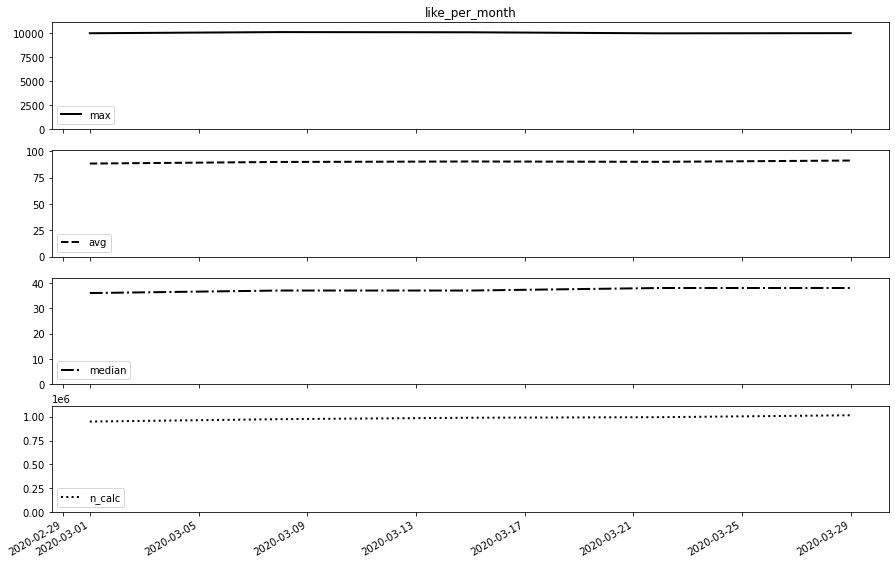

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def metric_qa_plot(qa_data_df, metric_name,**kwargs):
    plt.figure(  figsize=[15,10])
    qa_subplot(qa_data_df,'max',1,None)
    plt.title(metric_name)
    qa_subplot(qa_data_df,'avg',2,'--')
    qa_subplot(qa_data_df,'median',3,'-.')
    qa_subplot(qa_data_df,'n_calc',4,':')
    plt.gca().figure.autofmt_xdate()
    return plt

def qa_subplot(qa_data_df, field, number, linestyle):
    plt.subplot(4, 1, number)
    plt.plot('metric_time', field, data=qa_data_df, marker='', linestyle=linestyle, color='black', linewidth=2, label=field)
    plt.ylim(0, ceil(1.1 * qa_data_df[field].dropna().max()))
    plt.legend()

title="like_per_month"
#title="adview_per_month"
q_data=session.query(Metric, MetricName.metric_name).join(MetricName, MetricName.metric_name_id == Metric.metric_name_id)
data_metric=pd.read_sql(q_data.statement, engine)

# looking to the medians
data_medians_pre=data_metric[["metric_time", "metric_value", "metric_name"]].set_index(["metric_time","metric_name"])
data_medians=data_medians_pre.groupby(["metric_time", "metric_name"]).median()
data_medians=data_medians.rename(columns={"metric_value":"median"})
#only_medians=data_medians[np.in1d(data_medians.index.get_level_values(1), title)]
#print(data_medians)

metricslist=list(metric_stats_over_time["metric_name"].value_counts().index)
print(metricslist)
data_old=metric_stats_over_time.loc[metric_stats_over_time["metric_name"]==title]
data_old=pd.merge(data_old, data_medians, on=["metric_time", "metric_name"])
#print(data_old)
metric_qa_plot(data_old, title)

pass


Showing only mean, min and max does not give hints to how the values are distributed.
With a violine chart we would get a better impression of the data.

setting clipping 146.0


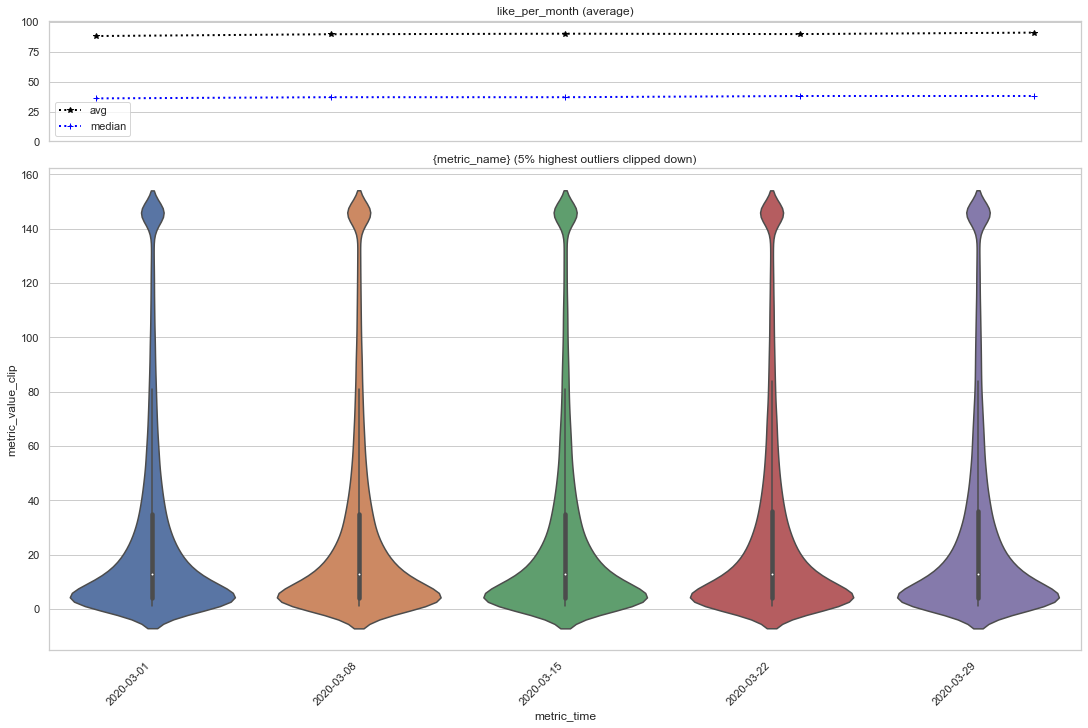

In [14]:
from scipy import stats
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

def metric_qa_violine(qa_data_df, qa_data_df2, alpha, metric_name,**kwargs):
    fig3 = plt.figure(constrained_layout=True, figsize=[15,10])
    gs = fig3.add_gridspec(15, 3)
    f3_ax1 = fig3.add_subplot(gs[3:, :])
    plt.title("{metric_name} (%1d%% highest outliers clipped down)" % ((1-alpha)*100))
    
    qa_sub_violine(qa_data_df,'metric_value_clip',f3_ax1,None)
    f3_ax2 = fig3.add_subplot(gs[:3, :])
    qa_subplot(qa_data_df2,'avg',f3_ax2,':')
    plt.title(f"{metric_name} (average)")
    return plt

def qa_sub_violine(qa_data_df, field, ax1, linestyle):
    ax=sns.violinplot(x="metric_time", y=field, data=qa_data_df, ax=ax1)
    x_dates = qa_data_df["metric_time"].dt.strftime('%Y-%m-%d').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
    #ax.legend()

def qa_subplot(qa_data_df, field, ax1, linestyle):
    ret1=ax1.plot("metric_time", 'avg', data=qa_data_df, marker='*', linestyle=linestyle, color='black', linewidth=2, label="avg")
    ret2=ax1.plot("metric_time", 'median', data=qa_data_df, marker='+', linestyle=linestyle, color='blue', linewidth=2, label="median")
    ax1.axis(ymin=0, ymax=ceil(1.1 * qa_data_df[field].dropna().max()))
    ax1.get_xaxis().set_visible(False)
    ax1.legend()


df=data_metric
alpha=0.95
percentiles_arg = df['metric_value'].quantile(alpha)
print(f"setting clipping {percentiles_arg}")
df['metric_value_clip']=df['metric_value'].map(lambda x: min(x, percentiles_arg))



# we reuse the data from the plot above "data_old"
metric_qa_violine(df, data_old, alpha, title)

pass


## metric coverage (§3.8)

In [15]:
"""
with 
date_range as (     
	select  '%from_yyyy-mm-dd'::timestamp as start_date,
		'%to_yyyy-mm-dd'::timestamp as end_date
), account_count as (    
	select count(distinct account_id) as n_account    
	from subscription s inner join date_range d on
	 s.start_date <= d.end_date
	and (s.end_date >= d.start_date or s.end_date is null)
)
select metric_name, 
	count(distinct m.account_id) as count_with_metric,
	n_account as n_account,    
	(count(distinct m.account_id))::float/n_account::float as pcnt_with_metric    ,
	avg(metric_value) as avg_value,    
	min(metric_value) as min_value,    
	max(metric_value) as max_value,
	min(metric_time)  as earliest_metric,
	max(metric_time) as last_metric
from metric m cross join account_count
inner join date_range on    
	metric_time >= start_date
	and metric_time <= end_date
inner join metric_name  n on m.metric_name_id = n.metric_name_id
inner join subscription s on s.account_id = m.account_id
    and s.start_date <= m.metric_time
    and (s.end_date >= m.metric_time or s.end_date is null)
group by metric_name,n_account
order by metric_name;
"""
from sqlalchemy import distinct, literal, and_, Float, cast

account_count = session.query(func.count(distinct(Subscription.account_id)).label("n_account"))\
    .filter(Subscription.start_date <= d_end_date,
        or_(Subscription.end_date >= d_start_date, Subscription.end_date == None))\
    .cte("account_count")

q_metric_coverage = session.query(MetricName.metric_name,
              func.count(distinct(Metric.account_id)).label("count_with_metric"), 
              account_count.c.n_account,\
              (cast(func.count(distinct(Metric.account_id)),Float) / account_count.c.n_account).label("pcnt_with_metric"),\
              func.avg(Metric.metric_value).label("avg_value"),\
              func.min(Metric.metric_value).label("min_value"),\
              func.max(Metric.metric_value).label("max_value"),\
              func.min(Metric.metric_time).label("earliest_metric"),\
              func.max(Metric.metric_time).label("last_metric"))\
        .join(MetricName, Metric.metric_name_id==MetricName.metric_name_id)\
        .join(account_count, literal(True))\
        .join(Subscription, and_(
            Metric.account_id==Subscription.account_id,
            Subscription.start_date <= Metric.metric_time,
            or_(Subscription.end_date >= Metric.metric_time, Subscription.end_date == None)))\
        .filter(Metric.metric_time>=d_start_date, Metric.metric_time<=d_end_date)\
        .group_by(MetricName.metric_name,Metric.metric_name_id, account_count.c.n_account)\
        .order_by(MetricName.metric_name)\
#        .filter(Metric.account_id<100)


metric_coverage = pd.read_sql(q_metric_coverage.statement, engine)
print(metric_coverage)
pass



           metric_name  count_with_metric  n_account  pcnt_with_metric  \
0     adview_per_month              11132      11496          0.968337   
1    dislike_per_month              10963      11496          0.953636   
2       like_per_month              11236      11496          0.977383   
3    message_per_month              11158      11496          0.970598   
4  newfriend_per_month              10545      11496          0.917276   
5       post_per_month              11133      11496          0.968424   
6      reply_per_month              10672      11496          0.928323   
7   unfriend_per_month               4777      11496          0.415536   

   avg_value  min_value  max_value earliest_metric last_metric  
0  39.036435        1.0     1081.0      2020-03-01  2020-03-29  
1  16.180230        1.0      426.0      2020-03-01  2020-03-29  
2  93.285917        1.0    10089.0      2020-03-01  2020-03-29  
3  61.867369        1.0    10029.0      2020-03-01  2020-03-29  
4   7.33

## events per day (§3.9)

In [16]:
"""
with
date_range as (    
	select i::timestamp as calc_date 
from generate_series('%from_yyyy-mm-dd', '%to_yyyy-mm-dd', '1 day'::interval) i
)
select event_time::date as event_date,   
	count(*) as n_event
  	/* , sum(%field2sum) as total_%event2measure_%field2sum */
from date_range left outer join event e on calc_date=event_time::date
inner join event_type t on t.event_type_id=e.event_type_id
where t.event_type_name='%event2measure'
group by event_date    
order by event_date
"""
from sqlalchemy import Column, Date, Integer, cast

# we need to create a temporary Table containing a sequence of Dates
meta=MetaData(bind=engine)
if "schema" in db_options:
    meta.schema = db_options["schema"]
TmpDailyVec = Table('tmp_daily_vec', meta, 
                   Column('id', Integer, primary_key=True, autoincrement=True),
                   Column('calc_date', Date))

def create_temp_daily(d_start_date, d_end_date):
    #print(sorted(dir(TmpDaysVec)))
    if TmpDailyVec.exists():
        TmpDailyVec.drop()
    TmpDailyVec.create()
    # storing a temporary table to the data base with pandas
    dates=pd.date_range(d_start_date, d_end_date, freq="1D").to_frame().rename(columns={0:"calc_date"})
    dates.index.rename("id")
    dates.to_sql("tmp_daily_vec", con=engine, **db_options, if_exists='append', index=False)
    session.commit()

create_temp_daily(d_start_date, d_end_date)

# be carefule when using sqlite
# for sqlite you need to use the cast "func.DATE"
#    see reference:
#    https://stackoverflow.com/questions/17333014/convert-selected-datetime-to-date-in-sqlalchemy
events_per_day = session.query(
        Event.event_type_id.label("event_type_id"),
        func.DATE(Event.event_time).label("calc_date"),
        func.count(Event.event_time).label("n_event"))\
    .group_by(Event.event_type_id,"calc_date")\
    .cte("events_per_day")
q_events_per_day = session.query(
        EventType.event_type_name,
        #events_per_day.c.event_type_id,
        TmpDailyVec.c.calc_date.label("event_date"),
        events_per_day.c.n_event
        )\
    .join(events_per_day, func.DATE(TmpDailyVec.c.calc_date)==events_per_day.c.calc_date)\
    .join(EventType, EventType.event_type_id==events_per_day.c.event_type_id)\
    .order_by("event_type_id","event_date") \
    .filter(EventType.event_type_name == "adview")

events_per_day = pd.read_sql(q_events_per_day.statement, engine)
print(events_per_day)

   event_type_name  event_date  n_event
0           adview  2020-03-01    16915
1           adview  2020-03-02    13972
2           adview  2020-03-03    13996
3           adview  2020-03-04    13304
4           adview  2020-03-05    13941
5           adview  2020-03-06    16066
6           adview  2020-03-07    16884
7           adview  2020-03-08    16866
8           adview  2020-03-09    14679
9           adview  2020-03-10    13372
10          adview  2020-03-11    14494
11          adview  2020-03-12    13830
12          adview  2020-03-13    14935
13          adview  2020-03-14    14870
14          adview  2020-03-15    14856
15          adview  2020-03-16    13564
16          adview  2020-03-17    14517
17          adview  2020-03-18    14967
18          adview  2020-03-19    14292
19          adview  2020-03-20    15081
20          adview  2020-03-21    15245
21          adview  2020-03-22    15745
22          adview  2020-03-23    15376
23          adview  2020-03-24    15487


## plotting the events (§3.10)

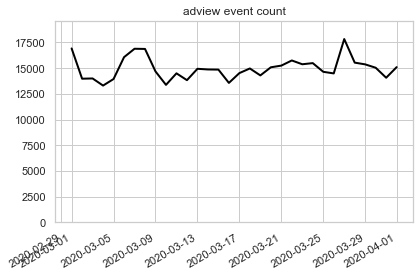

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def event_count_plot(qa_data_df, event_name,**kwargs):
    #event_data_path = qa_data_path + '_' + event_name + '.csv'
    #qa_data_df=pd.read_csv(event_data_path)
    plt.figure(figsize=(6, 4))
    plt.plot('event_date', 'n_event', data=qa_data_df, marker='', color='black', linewidth=2)
    plt.ylim(0, ceil(1.1 * qa_data_df['n_event'].dropna().max()))
    plt.title('{} event count'.format(event_name))
    plt.gca().figure.autofmt_xdate()
    #plt.xticks(list(filter(lambda x:x.endswith(("01")),qa_data_df['event_date'].tolist())))
    plt.tight_layout()
    #save_to_path=event_data_path.replace('.csv', '_' + event_name + '_event_qa.png')
    #print('Saving metric qa plot to ' + save_to_path)
    #plt.savefig(save_to_path)
    #plt.close()

event_count_plot(events_per_day, "adview")

## events per account (§3.11)

In [18]:
"""
with 
date_range as (    
	select  '%from_yyyy-mm-dd'::timestamp as start_date,
		'%to_yyyy-mm-dd'::timestamp as end_date
), account_count as (    
	select count(distinct account_id) as n_account
	from subscription s inner join date_range d on
	 s.start_date <= d.end_date
	and (s.end_date >= d.start_date or s.end_date is null)
)
select event_type_name, 
    count(*) as n_event,    
    n_account as n_account,  
    count(*)::float/n_account::float as events_per_account,
extract(days from end_date-start_date)::float/28 as n_months,    
(count(*)::float/n_account::float)/(extract(days from end_date-start_date)::float/28.0)  as events_per_account_per_month
from event e cross join account_count    
inner join event_type t on t.event_type_id=e.event_type_id
inner join date_range ON    
	event_time >= start_date
	and event_time <= end_date
group by e.event_type_id,n_account,end_date,start_date, event_type_name    
order by events_per_account_per_month desc;    
"""

from sqlalchemy import distinct, literal, and_, Float, cast, desc

account_count = session.query(func.count(distinct(Subscription.account_id)).label("n_account"))\
    .filter(Subscription.start_date <= d_end_date,
        or_(Subscription.end_date >= d_start_date, Subscription.end_date == None))\
    .cte("account_count")

n_months=days_between(d_start_date,d_end_date)/28

q_events_per_account = session.query(
        EventType.event_type_name, 
        func.count(Event.event_type_id).label("n_event"),
        account_count.c.n_account,
        (cast(func.count(Event.event_type_id),Float) / account_count.c.n_account).label("events_per_account"),
        literal(n_months).label("n_months"),
        (cast(func.count(Event.event_type_id), Float) / account_count.c.n_account / n_months).label("events_per_account_per_month"))\
    .join(EventType, Event.event_type_id==EventType.event_type_id )\
    .join(account_count, literal(True))\
    .filter(and_(Event.event_time>=d_start_date, Event.event_time<=d_end_date))\
    .group_by(EventType.event_type_name,Event.event_type_id, account_count.c.n_account)\
    .order_by(desc("events_per_account_per_month"))

events_per_account = pd.read_sql(q_events_per_account.statement, engine)
print(events_per_account)
pass


  event_type_name  n_event  n_account  events_per_account  n_months  \
0            like  1122997      11496           97.685891  1.107143   
1         message   738792      11496           64.265136  1.107143   
2            post   490857      11496           42.698069  1.107143   
3          adview   464211      11496           40.380219  1.107143   
4           reply   273888      11496           23.824635  1.107143   
5         dislike   186758      11496           16.245477  1.107143   
6       newfriend    79707      11496            6.933455  1.107143   
7        unfriend     3765      11496            0.327505  1.107143   

   events_per_account_per_month  
0                     88.232417  
1                     58.045929  
2                     38.565998  
3                     36.472456  
4                     21.519025  
5                     14.673334  
6                      6.262476  
7                      0.295811  


## account tenure (§3.12)

In [19]:
"""
with RECURSIVE date_range as (   
	select '%to_yyyy-mm-dd'::date as calc_date
),  earlier_starts AS (
	select account_id, min(start_date) as start_date    
	from subscription inner join date_range  
		on start_date <= calc_date
		and (end_date > calc_date or end_date is null)
	group by account_id

	UNION    
	
	select s.account_id, s.start_date    
	from subscription s inner join earlier_starts e 
		on s.account_id=e.account_id    
		and s.start_date < e.start_date    
		and s.end_date >= (e.start_date-31)    
	
) SELECT account_id, min(start_date) as earliest_start,     
calc_date-min(start_date) as subscriber_tenure_days
FROM earlier_starts cross join date_range    
group by account_id, calc_date    
order by account_id;
"""
from sqlalchemy import and_

d_calc_date=d_end_date

earlier_starts = session.query(Subscription.account_id, func.min(Subscription.start_date).label("start_date"))\
    .filter(Subscription.start_date <= d_calc_date,
        or_(Subscription.end_date > d_calc_date, Subscription.end_date == None))\
    .group_by(Subscription.account_id)\
    .cte(recursive=True, name="earlier_starts")

earlier_starts_L = session.query(Subscription.account_id, Subscription.start_date)\
    .join(earlier_starts, Subscription.account_id == earlier_starts.c.account_id)\
    .filter(and_(Subscription.start_date < earlier_starts.c.start_date,
        Subscription.end_date >= (earlier_starts.c.start_date-31)))

union_all = earlier_starts.union_all(earlier_starts_L)
subq=session.query(union_all).subquery()

# for postgres we can use this query
qr=session.query(
        subq.c.account_id, 
        func.min(subq.c.start_date).label("earliest_start"),
        (d_calc_date-func.min(subq.c.start_date)).label("subscriber_tenure_days")
    ) \
    .group_by(subq.c.account_id)\
    .order_by("account_id")\
    #.filter(subq.c.account_id<10)

# ... but for sqlite we need to use "julianday" do calculate the date diferences
qr=session.query(
        subq.c.account_id, 
        func.min(subq.c.start_date).label("earliest_start"),
        (func.julianday(d_calc_date)-func.julianday(func.min(subq.c.start_date))).label("subscriber_tenure_days")
        )\
    .group_by(subq.c.account_id)\
    #.filter(subq.c.account_id<10)
    
account_tenure = pd.read_sql(qr.statement, engine)
print(account_tenure)


       account_id earliest_start  subscriber_tenure_days
0               1     2020-01-21                    71.0
1               2     2020-01-13                    79.0
2               4     2020-01-29                    63.0
3               5     2020-01-07                    85.0
4               6     2020-01-18                    74.0
...           ...            ...                     ...
10876       13240     2020-04-01                     0.0
10877       13245     2020-04-01                     0.0
10878       13274     2020-04-01                     0.0
10879       13291     2020-04-01                     0.0
10880       13300     2020-04-01                     0.0

[10881 rows x 3 columns]


## account tenure insert (§3.13)

In [20]:
"""
with RECURSIVE date_vals AS (    
select i::timestamp as metric_date     
from generate_series('%from_yyyy-mm-dd', '%to_yyyy-mm-dd', '7 day'::interval) i
),
earlier_starts AS    
(
	select account_id, metric_date, min(start_date) as start_date    
	from subscription inner join date_vals
		on start_date <= metric_date    
		and (end_date > metric_date or end_date is null)
	group by account_id, metric_date

	UNION

	select s.account_id, metric_date, s.start_date    
	from subscription s inner join earlier_starts e
		on s.account_id=e.account_id
		and s.start_date < e.start_date
		and s.end_date >= (e.start_date-31)

)
insert into metric (account_id,metric_time,metric_name_id, metric_value)
SELECT account_id, metric_date, %new_metric_id as metric_name_id, extract(days from metric_date-min(start_date)) as metric_value
FROM earlier_starts
group by account_id, metric_date
order by account_id, metric_date
ON CONFLICT DO NOTHING;
"""
from sqlalchemy import literal, select

earlier_starts = session.query(Subscription.account_id, (TmpDaysVec.c.end_date).label("metric_date"), func.min(Subscription.start_date).label("start_date"))\
    .join(TmpDaysVec, and_(Subscription.start_date <= TmpDaysVec.c.end_date,
        or_(Subscription.end_date > TmpDaysVec.c.end_date, Subscription.end_date == None)))\
    .group_by(Subscription.account_id, "metric_date")\
    .cte(recursive=True, name="earlier_starts")

earlier_starts_L = session.query(Subscription.account_id, earlier_starts.c.metric_date, Subscription.start_date)\
    .join(earlier_starts, Subscription.account_id == earlier_starts.c.account_id)\
    .filter(and_(Subscription.start_date < earlier_starts.c.start_date,
        Subscription.end_date >= (earlier_starts.c.start_date-31)))


metric_id=session.query(MetricName.metric_name_id).filter(MetricName.metric_name=="account_tenure").one()[0]

# delete if existing already
session.commit()
old_metrics=session.query(Metric).filter(Metric.metric_name_id==metric_id)
old_metrics.delete()
session.commit()


union_all = earlier_starts.union_all(earlier_starts_L)
subq=session.query(union_all).subquery()
qr=session.query(
        subq.c.account_id,
        subq.c.metric_date.label("metric_time"),
        literal(metric_id).label("metric_name_id"),
        # for postgres we can use this
        #(subq.c.metric_date-func.min(subq.c.start_date)).label("metric_value"),
        # ...but for sqlite we need to use "juliandate"
        (func.julianday(subq.c.metric_date)
             -func.julianday(func.min(subq.c.start_date))).label("metric_value"),

    ) \
    .group_by(subq.c.account_id,  subq.c.metric_date)\
    .order_by("account_id",  subq.c.metric_date)

account_tenure = pd.read_sql(qr.statement, engine)
print(account_tenure)

new_metrics_insert=qr.cte("new_metrics_insert")
select_stm=select([new_metrics_insert.c.account_id, new_metrics_insert.c.metric_time, new_metrics_insert.c.metric_name_id, new_metrics_insert.c.metric_value])
columns=['account_id', 'metric_time', 'metric_name_id', 'metric_value']
session.execute(Metric.__table__.insert().from_select(columns, select_stm))
session.commit()



       account_id metric_time  metric_name_id  metric_value
0               1  2020-03-01               9          40.0
1               1  2020-03-08               9          47.0
2               1  2020-03-15               9          54.0
3               1  2020-03-22               9          61.0
4               1  2020-03-29               9          68.0
...           ...         ...             ...           ...
52909       12099  2020-03-15               9          11.0
52910       12099  2020-03-22               9          18.0
52911       12099  2020-03-29               9          25.0
52912       12100  2020-03-22               9           6.0
52913       12100  2020-03-29               9          13.0

[52914 rows x 4 columns]


## mrr, unit_quantity, billing_period (§§ 3.14/15/16)

In [21]:
"""
with date_vals AS (
  	select i::timestamp as metric_date
from generate_series('%from_yyyy-mm-dd', '%to_yyyy-mm-dd', '7 day'::interval) i
)

select account_id, metric_date, sum(mrr) as total_mrr, min(bill_period_months) as billing_period
from subscription inner join date_vals
on start_date <= metric_date
and (end_date > metric_date or end_date is null)
group by account_id, metric_date

"""

"""
select account_id, metric_date, sum(quantity) as total_UNIT
from subscription inner join date_vals
on start_date <= metric_date
and (end_date > metric_date or end_date is null)
where units = 'UNIT'
group by account_id, metric_date
"""
from sqlalchemy import func

q_quants = session.query( 
        Subscription.account_id,
        (TmpDaysVec.c.end_date).label("metric_date"),
        func.sum(Subscription.mrr).label("total_mrr"),
        func.sum(Subscription.bill_period_months).label("billing_period"))\
    .join(TmpDaysVec, 
          and_(Subscription.start_date <= TmpDaysVec.c.end_date, 
                or_(Subscription.end_date > TmpDaysVec.c.end_date, Subscription.end_date == None)))\
    .group_by(Subscription.account_id, "metric_date")\
    .order_by(Subscription.account_id, "metric_date")

quants = pd.read_sql(q_quants.statement, engine)
print(quants)

q_quants_unit = session.query( 
        Subscription.account_id,
        (TmpDaysVec.c.end_date).label("metric_date"),
        func.sum(Subscription.quantity).label("total_UNIT"))\
    .join(TmpDaysVec, 
          and_(Subscription.start_date <= TmpDaysVec.c.end_date, 
                or_(Subscription.end_date > TmpDaysVec.c.end_date, Subscription.end_date == None)))\
    .group_by(Subscription.account_id, "metric_date")\
    .order_by(Subscription.account_id, "metric_date")\
    #.filter(Subscription.units == "UNIT")

quants_unit = pd.read_sql(q_quants_unit.statement, engine)
print(quants_unit)


       account_id metric_date  total_mrr  billing_period
0               1  2020-03-01       50.0               1
1               1  2020-03-08       50.0               1
2               1  2020-03-15       50.0               1
3               1  2020-03-22       50.0               1
4               1  2020-03-29       50.0               1
...           ...         ...        ...             ...
52909       12099  2020-03-15      100.0               1
52910       12099  2020-03-22      100.0               1
52911       12099  2020-03-29      100.0               1
52912       12100  2020-03-22       50.0               1
52913       12100  2020-03-29       50.0               1

[52914 rows x 4 columns]
       account_id metric_date total_UNIT
0               1  2020-03-01       None
1               1  2020-03-08       None
2               1  2020-03-15       None
3               1  2020-03-22       None
4               1  2020-03-29       None
...           ...         ...        ...
529